# Falkon Use Case: NYC Taxi Fare Prediction - Regression

## 1. Environment Setup

In [1]:
# --- Installation ---
import os
import sys

# Check if environment initialized
try:
    import falkon

    ENV_INITIALIZED = True
except ImportError:
    ENV_INITIALIZED = False

if not ENV_INITIALIZED:
    print("Installing dependencies...")
    # Downgrade to PyTorch for CUDA 12.1
    !pip install --quiet torch==2.2.0+cu121 torchvision==0.17.0+cu121 torchaudio==2.2.0+cu121 --index-url https://download.pytorch.org/whl/cu121
    # Downgrade to KeOps 2.2
    !pip install --quiet pykeops==2.2
    # Install Falkon from pre-compiled wheel for the specific Torch+CUDA version
    !pip install --quiet falkon -f https://falkon.dibris.unige.it/torch-2.2.0_cu121.html
    # Install other necessary libraries
    !pip install --quiet pandas pyarrow scikit-learn seaborn matplotlib py-cpuinfo psutil
    # Downgrade to NumPy 1.26.4
    !pip install --quiet numpy==1.26.4
    print("Dependencies installed successfully.")
    # Programmatically exit to restart the runtime.
    os._exit(0)
else:
    print("Dependencies already installed.")


Dependencies already installed.


In [2]:
def get_system_info(bench="flk"):
    """Gathers and returns key hardware and software information as a dictionary."""
    info = {}
    try:
        # Environment
        info["python_version"] = platform.python_version()
        info["python_executable"] = sys.executable

        # Software
        info["torch_version"] = torch.__version__
        info["numpy_version"] = np.__version__
        info["pandas_version"] = pd.__version__
        info["sklearn_version"] = sklearn.__version__

        # Benchmark-specific libraries
        if bench == "flk":
            info["falkon_version"] = falkon.__version__
            info["pykeops_version"] = pykeops.__version__
        elif bench == "xgb":
            info["xgboost_version"] = xgb.__version__
            info["shap_version"] = shap.__version__

        # Hardware
        info["os"] = f"{platform.system()} {platform.release()}"
        info["cpu_model"] = cpuinfo.get_cpu_info().get("brand_raw", "N/A")
        info["ram_total_gb"] = psutil.virtual_memory().total / (1024**3)

        # GPU Hardware
        if torch.cuda.is_available():
            info["gpu_model"] = torch.cuda.get_device_name(0)
            info["gpu_vram_gb"] = torch.cuda.get_device_properties(0).total_memory / (
                1024**3
            )
            info["cuda_version"] = torch.version.cuda
        else:
            info["gpu_model"] = "N/A"
            info["gpu_vram_gb"] = 0
            info["cuda_version"] = "N/A"
    except Exception as e:
        print(f"Could not retrieve all system info: {e}")
    return info


In [3]:
# --- Library Imports ---

# Modeling and Computation
import falkon
import torch
import pykeops
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization and Utilities
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import time
import platform
import psutil
import cpuinfo
import requests
import gc
from IPython.display import display

print("Libraries imported successfully.")
get_system_info()


Libraries imported successfully.


{'python_version': '3.11.13',
 'python_executable': '/usr/bin/python3',
 'torch_version': '2.2.0+cu121',
 'numpy_version': '1.26.4',
 'pandas_version': '2.2.2',
 'sklearn_version': '1.6.1',
 'falkon_version': '0.8.5',
 'pykeops_version': '2.2',
 'os': 'Linux 6.1.123+',
 'cpu_model': 'Intel(R) Xeon(R) CPU @ 2.20GHz',
 'ram_total_gb': 83.4760627746582,
 'gpu_model': 'NVIDIA A100-SXM4-40GB',
 'gpu_vram_gb': 39.55743408203125,
 'cuda_version': '12.1'}

## 2. Data Preparation

In [4]:
def download_taxi(final_path="taxi_data.parquet"):
    """Downloads and processes data if not already present."""

    # Load consolidate data if exists
    if os.path.exists(final_path):
        print(f"Consolidated data file found at '{final_path}'. Skipping processing.")
        return final_path

    print("Consolidated data not found. Starting download and processing...")

    # Download monthly taxi data
    taxi_data_urls = {
        f"yellow_tripdata_2024-{month:02d}.parquet": f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-{month:02d}.parquet"
        for month in range(1, 13)
    }

    for taxi_filename, taxi_url in taxi_data_urls.items():
        if not os.path.exists(taxi_filename):
            print(f"Downloading {taxi_filename}...")
            try:
                response = requests.get(taxi_url)
                response.raise_for_status()
                with open(taxi_filename, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"{taxi_filename} downloaded successfully.")
            except Exception as e:
                print(f"Error downloading {taxi_filename}: {e}")
        else:
            print(f"{taxi_filename} already exists.")

    # Helper function: Process
    def process_taxi(df, TARGET_COL, FEATURE_COLS):
        """Processes a single taxi DataFrame chunk."""

        # Convert to datetime objects
        df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
        df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

        # Calculate trip duration in minutes
        df["duration"] = (
            df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
        ).dt.total_seconds() / 60

        # Extract features from datetime
        df["pickup_day"] = df["tpep_pickup_datetime"].dt.dayofweek
        df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour

        # Basic filtering
        df = df[df["fare_amount"].between(2.5, 200)]
        df = df[df["trip_distance"].between(0.1, 100)]
        df = df[df["duration"].between(1, 360)]
        df = df[df["passenger_count"].between(1, 6)]

        # Select features and target
        df = df[FEATURE_COLS + [TARGET_COL]]

        # Drop NA's
        df.dropna(inplace=True)

        return df

    # Helper function: Consolidate
    def consolidate_taxi(
        files,
        TARGET_COL,
        FEATURE_COLS,
        final_path="taxi_data.parquet",
        batch_size=1_000_000,
    ):
        """Reads and processes files in chunks, then saves to disk"""

        writer = None
        schema = None

        if os.path.exists(final_path):
            os.remove(final_path)

        # Read and process files in chunks
        for i, filename in enumerate(files):
            print(f"--- Processing file {i+1}/{len(files)}: {filename} ---")
            parquet_file = pq.ParquetFile(filename)

            for batch_num, batch in enumerate(
                parquet_file.iter_batches(batch_size=batch_size)
            ):
                print(f"  Processing batch {batch_num + 1}...")
                chunk_df = batch.to_pandas()
                processed_chunk = process_taxi(chunk_df, TARGET_COL, FEATURE_COLS)

                if not processed_chunk.empty:
                    table = pa.Table.from_pandas(processed_chunk)
                    if writer is None:
                        print("  Initializing Parquet writer...")
                        schema = table.schema
                        writer = pq.ParquetWriter(final_path, schema)

                    writer.write_table(table.cast(schema, safe=False))
                    del table

                del chunk_df, processed_chunk, batch
                gc.collect()

        if writer:
            writer.close()
            print(f"\nAll files processed and saved to {final_path}")
            return final_path
        else:
            print("\nNo data was written.")
            return None

    # Consolidate data
    taxi_filenames = list(taxi_data_urls.keys())
    taxi_path = consolidate_taxi(taxi_filenames, TARGET_COL, FEATURE_COLS)

    return taxi_path


In [5]:
def load_taxi(data_path, n_samples_train):
    """Loads and prepares a specific number of samples for training."""
    if data_path is None:
        raise FileNotFoundError(
            "Consolidated data path is not available. Run data prep."
        )

    # --- Caching Logic: Define cache path and check for existence ---
    base_name, _ = os.path.splitext(data_path)
    cache_path = f"{base_name}_N{n_samples_train}.pt"

    if os.path.exists(cache_path):
        print(f"Cache found! Loading pre-processed tensors from '{cache_path}'...")
        data_dict = torch.load(cache_path)
        X_train_t = data_dict["X_train"]
        y_train_t = data_dict["y_train"]
        X_test_t = data_dict["X_test"]
        y_test_t = data_dict["y_test"]
        print(
            f"Tensors loaded. Train shape: {X_train_t.shape}, Test shape: {X_test_t.shape}"
        )
        return X_train_t, y_train_t, X_test_t, y_test_t

    # --- If cache not found, run the full processing pipeline ---
    print(
        f"Cache not found for N={n_samples_train}. Starting full data processing pipeline..."
    )

    full_df = pd.read_parquet(data_path)
    print(f"Full data loaded. Shape: {full_df.shape}")

    print(f"\nLoading and preparing data for N_train = {n_samples_train}...")

    # Split full dataset to maintain a consistent test set pool
    train_pool_df, test_pool_df = train_test_split(
        full_df, test_size=0.2, random_state=GLOBAL_PARAMS["RANDOM_STATE"]
    )
    del full_df
    gc.collect()
    print(
        f"Data split. Train pool shape: {train_pool_df.shape}, Test pool shape: {test_pool_df.shape}"
    )

    # Subsample training and test sets
    train_df = train_pool_df.sample(
        n=n_samples_train, random_state=GLOBAL_PARAMS["RANDOM_STATE"]
    )
    test_df = test_pool_df.sample(
        n=GLOBAL_PARAMS["MAX_TEST_SAMPLES"], random_state=GLOBAL_PARAMS["RANDOM_STATE"]
    )
    del train_pool_df, test_pool_df
    gc.collect()

    # Separate features and target
    X_train_df, y_train_df = train_df[FEATURE_COLS], train_df[TARGET_COL]
    X_test_df, y_test_df = test_df[FEATURE_COLS], test_df[TARGET_COL]
    del train_df, test_df
    gc.collect()

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled = scaler.transform(X_test_df)
    del X_train_df, X_test_df
    gc.collect()

    # Convert to PyTorch Tensors
    X_train_t = torch.from_numpy(X_train_scaled).contiguous()
    y_train_t = torch.from_numpy(y_train_df.values).view(-1, 1)
    X_test_t = torch.from_numpy(X_test_scaled).contiguous()
    y_test_t = torch.from_numpy(y_test_df.values).view(-1, 1)
    del X_train_scaled, y_train_df, X_test_scaled, y_test_df
    gc.collect()

    # --- Caching Logic: Save the newly created tensors to disk ---
    print(f"\nSaving processed tensors to cache at '{cache_path}'...")
    data_to_save = {
        "X_train": X_train_t,
        "y_train": y_train_t,
        "X_test": X_test_t,
        "y_test": y_test_t,
    }
    torch.save(data_to_save, cache_path)
    print("Save complete.")

    print(
        f"\nData prepared. Train shape: {X_train_t.shape}, Test shape: {X_test_t.shape}"
    )
    return X_train_t, y_train_t, X_test_t, y_test_t


In [6]:
# Set target variable
TARGET_COL = "fare_amount"

# Set feature columns
FEATURE_COLS = [
    "VendorID",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "duration",
    "pickup_hour",
    "pickup_day",
]

# Download data
CONSOLIDATED_DATA_PATH = download_taxi()


Consolidated data file found at 'taxi_data.parquet'. Skipping processing.


## 3. Methodology & Helper Functions

In [7]:
def timed_execution(func, *args, **kwargs):
    """Measures execution time of a function, averaging over N_RUNS repetitions."""
    times = []
    result = None
    print(
        f"Benchmarking '{func.__name__}' for {GLOBAL_PARAMS['N_RUNS']} repetitions..."
    )

    # Run N_RUNS times for timing
    for i in range(GLOBAL_PARAMS["N_RUNS"]):
        # Start time
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = time.time()

        # Function call
        result = func(*args, **kwargs)

        # Stop time
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()

        times.append(end_time - start_time)
        print(
            f"  Repetition {i+1}/{GLOBAL_PARAMS['N_RUNS']} complete in {times[-1]:.4f}s"
        )

    # Report average time
    avg_time = np.mean(times)
    print(f"Average execution time: {avg_time:.4f}s")

    # Return last model result, average time, and individual timings
    return result, avg_time, times


In [8]:
def evaluate_regression(y_true, y_pred):
    """Calculates regression metrics and returns them as a dictionary."""
    y_true_np = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    y_pred_np = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred

    # Calculate standard regression metrics
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_np, y_pred_np)

    # Report results
    print("Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")

    # Return metrics as a dictionary
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


## 4. Experiment Configuration

In [9]:
# --- A. Experiment Naming ---
# Name for the output CSV file.
EXPERIMENT_NAME = "benchmark_falkon_taxi_1"

# --- B. Benchmark Selection ---
# Global flags to enable/disable entire benchmark categories.
RUN_CONTROLS = {
    "RUN_FALKON_GPU": True,
    "RUN_FALKON_CPU": True,
    "RUN_SKLEARN_CPU": True,
}

# --- C. Experiment Run Definitions ---
# Experiment Configurations #1
# List of N to benchmark.
n_samples_list = [
    1_000,
    2_000,
    5_000,
    10_000,
    20_000,
    50_000,
    100_000,
    200_000,
    500_000,
    1_000_000,
    2_000_000,
    5_000_000,
    10_000_000,
    20_000_000,
    50_000_000,
]

# Hardcores model runs up to specific N.
# Adds M as log(N) * sqrt(N)
EXPERIMENT_CONFIGS_1 = [
    {
        "n_samples": n,
        "m_points": int(np.log(n) * np.sqrt(n)),
        "FALKON_GPU": True if n <= 2_000_000 else False,
        "FALKON_CPU": True if n <= 200_000 else False,
        "SKLEARN_CPU": True if n <= 10_000 else False,
    }
    for n in n_samples_list
]

# Experiment Configurations #2
N_FIXED = 5_000_000
SQRT_N = np.sqrt(N_FIXED)

# Hardcores model runs to a specific N.
# Adds several M to test effect on model performance.
EXPERIMENT_CONFIGS_2 = [
    {
        "n_samples": N_FIXED,
        "m_points": int(m),
        "FALKON_GPU": True,
        "FALKON_CPU": False,
        "SKLEARN_CPU": False,
    }
    for m in np.concatenate((
        np.linspace(start=0.1 * SQRT_N, stop=1.0 * SQRT_N, num=10),
        np.linspace(start=1.0 * SQRT_N, stop=10.0 * SQRT_N, num=10)[1:]
    ))
]

# --- D. Global Model and Run Parameters ---
GLOBAL_PARAMS = {
    "N_RUNS": 5,  # Repetitions for averaging time
    "RANDOM_STATE": 6,  # Seed for reproducibility
    "MAX_TEST_SAMPLES": 100_000,  # Fixed size for test set
    "FALKON_SIGMA": 15.0,  # Gaussian kernel width (sigma)
    "FALKON_PENALTY": 1e-6,  # Regularization penalty (lambda)
    "FALKON_MAXITER": 20,  # Max iterations for CG solver
}

EXPERIMENT_CONFIGS = EXPERIMENT_CONFIGS_1

# Seed for reproducibility
np.random.seed(GLOBAL_PARAMS["RANDOM_STATE"])
torch.manual_seed(GLOBAL_PARAMS["RANDOM_STATE"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(GLOBAL_PARAMS["RANDOM_STATE"])


In [10]:
def run_falkon_krr(data_path, N, M, use_cpu):
    """Runs a full Falkon benchmark and returns a dictionary of results."""
    model_label = "Falkon (CPU)" if use_cpu else "Falkon (GPU)"
    print(f"\n--- Starting Benchmark for: {model_label} ---")

    # Loading
    X_train_orig, y_train_orig, X_test_orig, y_test_orig = load_taxi(data_path, N)
    if use_cpu:
        target_dtype = torch.float64
    else:
        target_dtype = torch.float32

    X_train = X_train_orig.to(dtype=target_dtype)
    del X_train_orig
    y_train = y_train_orig.to(dtype=target_dtype)
    del y_train_orig
    X_test = X_test_orig.to(dtype=target_dtype)
    del X_test_orig
    y_test = y_test_orig.to(dtype=target_dtype)
    del y_test_orig
    gc.collect()

    # Configuration
    falkon_options = falkon.FalkonOptions(
        keops_active="no" if use_cpu else "yes", use_cpu=use_cpu, debug=True
    )

    falkon_params = {
        "kernel": falkon.kernels.GaussianKernel(sigma=GLOBAL_PARAMS["FALKON_SIGMA"]),
        "penalty": GLOBAL_PARAMS["FALKON_PENALTY"],
        "M": M,
        "maxiter": GLOBAL_PARAMS["FALKON_MAXITER"],
        "seed": GLOBAL_PARAMS["RANDOM_STATE"],
        "options": falkon_options,
    }

    # Training
    def train_falkon():
        model = falkon.Falkon(**falkon_params)
        model.fit(X_train, y_train)
        return model

    model, train_time, train_times = timed_execution(train_falkon)

    del X_train, y_train
    gc.collect()

    # Prediction
    def predict_falkon():
        preds = model.predict(X_test)
        return preds

    pred, pred_time, pred_times = timed_execution(predict_falkon)

    # Evaluation
    metrics = evaluate_regression(y_test, pred)

    # Results
    results = {
        "model": model,
        "train_time": train_time,
        "train_times": train_times,
        "pred_time": pred_time,
        "pred_times": pred_times,
        "metrics": metrics,
        "model_label": model_label,
        "status": "Success",
    }

    print(f"--- Benchmark for {model_label} complete. ---")
    return results


In [11]:
def run_sklearn_kernelridge(data_path, N):
    """Runs a Scikit-learn KernelRidge benchmark and returns results."""
    model_label = "Scikit-learn KernelRidge (CPU)"

    if N == 0:
        print(f"\n--- Skipping Benchmark for: {model_label} ---")
        return {
            "model": None,
            "train_time": -1,
            "train_times": [],
            "pred_time": -1,
            "pred_times": [],
            "metrics": {},
            "model_label": model_label,
            "status": "MemoryError",
        }

    try:
        print(f"\n--- Starting Benchmark for: {model_label} ---")

        # Loading
        X_train_orig, y_train_orig, X_test_orig, y_test_orig = load_taxi(data_path, N)

        X_train = X_train_orig.cpu().numpy()
        del X_train_orig
        y_train = y_train_orig.cpu().numpy()
        del y_train_orig
        X_test = X_test_orig.cpu().numpy()
        del X_test_orig
        y_test = y_test_orig.cpu().numpy()
        del y_test_orig
        gc.collect()

        # Training
        def train_skl():
            SKL_GAMMA = 1 / (2 * GLOBAL_PARAMS["FALKON_SIGMA"] ** 2)
            model = KernelRidge(kernel="rbf", gamma=SKL_GAMMA)
            model.fit(X_train, y_train)
            return model

        model, train_time, train_times = timed_execution(train_skl)

        del X_train, y_train
        gc.collect()

        # Prediction
        def predict_skl():
            preds = model.predict(X_test)
            return preds

        pred, pred_time, pred_times = timed_execution(predict_skl)

        # Evaluation
        metrics = evaluate_regression(y_test, pred)

        # Results
        results = {
            "model": model,
            "train_time": train_time,
            "train_times": train_times,
            "pred_time": pred_time,
            "pred_times": pred_times,
            "metrics": metrics,
            "model_label": model_label,
            "status": "Success",
        }

        print(f"--- Benchmark for {model_label} complete. ---")
        return results
    except MemoryError:
        print("!!! Scikit-learn failed due to MemoryError. !!!")
        return {
            "model": None,
            "train_time": -1,
            "train_times": [],
            "pred_time": -1,
            "pred_times": [],
            "metrics": {},
            "model_label": model_label,
            "status": "MemoryError",
        }
    except Exception as e:
        print(f"!!! Scikit-learn failed due to an exception: {e} !!!")
        return {
            "model": None,
            "train_time": -1,
            "train_times": [],
            "pred_time": -1,
            "pred_times": [],
            "metrics": {},
            "model_label": model_label,
            "status": "Error",
        }


## 5. Execution Engine

In [12]:
all_run_results = []
system_info = get_system_info()

print("Starting experiment runs...")
print("---" * 20)

for i, config in enumerate(EXPERIMENT_CONFIGS):
    n_samples = config["n_samples"]
    m_points = config["m_points"]

    print(f"\n>>> RUN {i+1}/{len(EXPERIMENT_CONFIGS)}: N={n_samples}, M={m_points} <<<")

    # Load and prepare data for the current configuration
    base_results = {**system_info, **config}

    # --- Run Falkon GPU ---
    if RUN_CONTROLS["RUN_FALKON_GPU"] and config["FALKON_GPU"]:
        # Use float32 for GPU for better performance (Tensor Core usage)
        gpu_results = run_falkon_krr(
            CONSOLIDATED_DATA_PATH,
            N=n_samples,
            M=m_points,
            use_cpu=False,
        )
        all_run_results.append(
            {**base_results, "run_type": "Falkon (GPU)", **gpu_results}
        )

    # --- Run Falkon CPU ---
    if RUN_CONTROLS["RUN_FALKON_CPU"] and config["FALKON_CPU"]:
        # Use float64 for CPU because float32 is numerically unstable on CPU
        cpu_results = run_falkon_krr(
            CONSOLIDATED_DATA_PATH,
            N=n_samples,
            M=m_points,
            use_cpu=True,
        )
        all_run_results.append(
            {**base_results, "run_type": "Falkon (CPU)", **cpu_results}
        )

    # --- Run Scikit-learn CPU ---
    if RUN_CONTROLS["RUN_SKLEARN_CPU"] and config["SKLEARN_CPU"]:
        skl_results = run_sklearn_kernelridge(
            CONSOLIDATED_DATA_PATH,
            N=n_samples,
        )
        all_run_results.append(
            {**base_results, "run_type": "Scikit-learn (CPU)", **skl_results}
        )

    # Moving to next Run!
    print(
        f"\n>>> RUN {i+1}/{len(EXPERIMENT_CONFIGS)}: N={n_samples}, M={m_points} COMPLETE <<<\n\n"
    )

print("\n\nAll experiment runs complete.")
print("---" * 20)


Starting experiment runs...
------------------------------------------------------------

>>> RUN 1/15: N=1000, M=218 <<<

--- Starting Benchmark for: Falkon (GPU) ---
Cache found! Loading pre-processed tensors from 'taxi_data_N1000.pt'...
Tensors loaded. Train shape: torch.Size([1000, 10]), Test shape: torch.Size([100000, 10])
Benchmarking 'train_falkon' for 5 repetitions...
MainProcess.MainThread::[Calcuating Preconditioner of size 218]
Preconditioner will run on CPU
--MainProcess.MainThread::[Kernel]
--MainProcess.MainThread::[Kernel] complete in 0.004s
--MainProcess.MainThread::[Cholesky 1]
--MainProcess.MainThread::[Cholesky 1] complete in 0.001s
--MainProcess.MainThread::[Copy triangular]
--MainProcess.MainThread::[Copy triangular] complete in 0.000s
--MainProcess.MainThread::[LAUUM(CPU)]
--MainProcess.MainThread::[LAUUM(CPU)] complete in 0.014s
--MainProcess.MainThread::[Cholesky 2]
--MainProcess.MainThread::[Cholesky 2] complete in 0.017s
MainProcess.MainThread::[Calcuating Pre

## 6. Results Summary & Export

--- Final Results Summary ---


,run_type,n_samples,m_points,status,train_time,train_times,pred_time,pred_times,RMSE,R2,cpu_model,gpu_model,ram_total_gb,gpu_vram_gb,python_version,torch_version,falkon_version
0,Falkon (GPU),1000,218,Success,0.402681,"[0.7115814685821533, 0.31197357177734375, 0.37...",0.166563,"[0.18233776092529297, 0.18667888641357422, 0.1...",4.648864,0.927902,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
1,Falkon (CPU),1000,218,Success,0.327982,"[0.5641109943389893, 0.4689044952392578, 0.208...",0.078092,"[0.08805203437805176, 0.08422684669494629, 0.0...",4.153988,0.942435,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
2,Scikit-learn (CPU),1000,218,Success,0.154272,"[0.1618032455444336, 0.16003084182739258, 0.13...",0.840725,"[0.8629145622253418, 0.8392481803894043, 0.831...",4.922936,0.919150,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
3,Falkon (GPU),2000,339,Success,0.354040,"[0.33994150161743164, 0.3388967514038086, 0.38...",0.003554,"[0.006240367889404297, 0.003144979476928711, 0...",4.503046,0.932354,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
4,Falkon (CPU),2000,339,Success,0.206787,"[0.21019268035888672, 0.21569442749023438, 0.2...",0.103285,"[0.10760951042175293, 0.1023857593536377, 0.10...",3.947515,0.948015,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
5,Scikit-learn (CPU),2000,339,Success,0.297968,"[0.17101764678955078, 0.240006685256958, 0.218...",1.637144,"[1.6210479736328125, 1.6159794330596924, 1.626...",4.483751,0.932932,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
6,Falkon (GPU),5000,602,Success,1.157378,"[1.0280306339263916, 0.9680824279785156, 1.151...",0.003300,"[0.004282236099243164, 0.0031588077545166016, ...",4.389547,0.935721,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
7,Falkon (CPU),5000,602,Success,0.338416,"[0.3385741710662842, 0.33877038955688477, 0.34...",0.173155,"[0.17377066612243652, 0.17192578315734863, 0.1...",3.684116,0.954721,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
8,Scikit-learn (CPU),5000,602,Success,0.892574,"[0.8509681224822998, 1.0144295692443848, 0.840...",4.134059,"[4.159111738204956, 4.07963752746582, 4.122614...",4.289389,0.938621,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5
9,Falkon (GPU),10000,921,Success,2.666775,"[2.5822548866271973, 3.0754852294921875, 2.564...",0.003515,"[0.0037033557891845703, 0.0045680999755859375,...",4.062001,0.944956,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,39.557434,3.11.13,2.2.0+cu121,0.8.5



Results successfully saved to 'benchmark_falkon_taxi_1.csv'

--- Visualization for Scalability (N) Benchmark ---


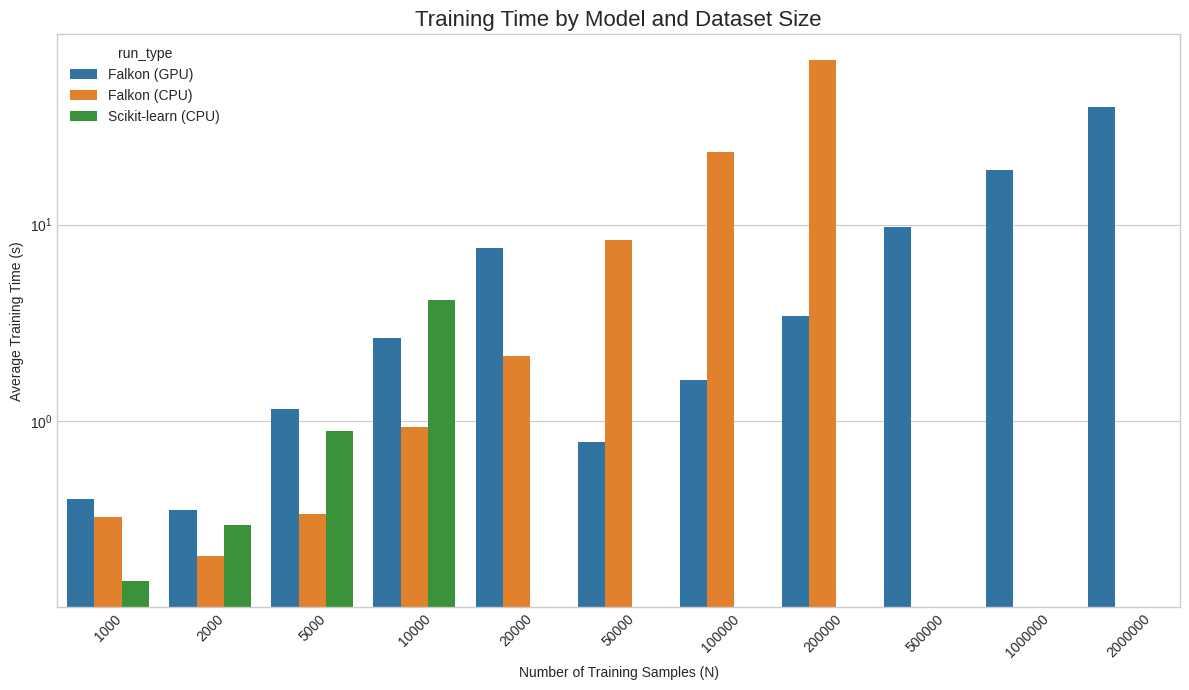

In [13]:
if all_run_results:
    # --- 1. Common Data Processing and Saving ---
    # Convert list of dictionaries to a DataFrame
    results_df = pd.DataFrame(all_run_results)
    metrics_df = results_df["metrics"].apply(pd.Series)
    results_df = pd.concat([results_df.drop("metrics", axis=1), metrics_df], axis=1)

    # Reorder columns for clarity
    col_order = [
        "run_type", "n_samples", "m_points", "status",
        "train_time", "train_times",
        "pred_time", "pred_times",
        "RMSE", "R2",
        "cpu_model", "gpu_model",
        "ram_total_gb", "gpu_vram_gb",
        "python_version", "torch_version", "falkon_version",
    ]
    # Filter to only existing columns to avoid errors
    results_df = results_df[[c for c in col_order if c in results_df.columns]]

    # Display results in the notebook
    print("--- Final Results Summary ---")
    display(results_df)

    # Save to CSV
    output_filename = f"{EXPERIMENT_NAME}.csv"
    results_df.to_csv(output_filename, index=False)
    print(f"\nResults successfully saved to '{output_filename}'")


    # --- 2. Conditional Visualization ---
    # Determine which experiment was run based on the results data.
    is_scalability_experiment = len(results_df['n_samples'].unique()) > 1
    is_m_impact_experiment = len(results_df['m_points'].unique()) > 1 and len(results_df['n_samples'].unique()) == 1

    # Plot for Experiment 1: Scalability in N
    if is_scalability_experiment:
        print("\n--- Visualization for Scalability (N) Benchmark ---")
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(12, 7))
        sns.barplot(data=results_df, x="n_samples", y="train_time", hue="run_type", ax=ax)
        ax.set_title("Training Time by Model and Dataset Size", fontsize=16)
        ax.set_ylabel("Average Training Time (s)")
        ax.set_xlabel("Number of Training Samples (N)")
        ax.set_yscale("log")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Plot for Experiment 2: Impact of M
    elif is_m_impact_experiment:
        print("\n--- Visualization for M-Impact Benchmark ---")
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.lineplot(data=results_df, x="m_points", y="RMSE", marker="o", ax=ax)
        ax.set_title("Model RMSE vs. Number of Inducing Points (M)", fontsize=16)
        ax.set_ylabel("RMSE (Root Mean Squared Error)")
        ax.set_xlabel("Number of Inducing Points (M)")
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

else:
    print("No results were generated.")